In [25]:
import cv2
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ---------- Image Processing ----------
def extract_contour(img_path, n_points=1000):
    """Extract contour curve (Nx2) from binary image."""
    # Charger l'image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {img_path}")
    
    # Appliquer un flou pour réduire le bruit
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Détecter les contours avec Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Trouver les contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        raise ValueError("Aucun contour détecté dans l'image")
    
    # Prendre le plus grand contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    
    # Si le contour a seulement 1 point, lever une erreur
    if contour.ndim == 1 or len(contour) < 10:
        raise ValueError("Contour trop petit ou dégénéré")
    
    # Rééchantillonner et normaliser
    contour = resample_curve(contour, n_points)
    contour = normalize_curve(contour)
    
    return contour

# ---------- SRVF Functions ----------
def curve_to_srvf(beta):
    """Convert curve (Nx2) to SRVF (Nx2)."""
    # Calculer les dérivées avec un pas constant
    n = len(beta)
    dt = 1.0 / n
    
    # Calculer le gradient
    beta_grad = np.gradient(beta, dt, axis=0)
    
    # Calculer les normes
    norms = np.linalg.norm(beta_grad, axis=1, keepdims=True)
    
    # Éviter la division par zéro
    norms = np.maximum(norms, 1e-8)
    
    # Calculer SRVF
    q = beta_grad / np.sqrt(norms)
    
    return q

def srvf_to_curve(q, start):
    """Reconstruct curve from SRVF q and starting point."""
    n = len(q)
    dt = 1.0 / n
    
    beta = np.zeros_like(q)
    beta[0] = start
    
    # Reconstruire la courbe par intégration
    for i in range(1, n):
        beta[i] = beta[i-1] + q[i-1] * np.linalg.norm(q[i-1]) * dt
    
    return beta

def resample_curve(curve, n=200):
    """Uniformly resample a curve to n points."""
    # Calculer la longueur cumulative le long de la courbe
    diff = np.diff(curve, axis=0)
    distances = np.sqrt(np.sum(diff**2, axis=1))
    cumulative_length = np.cumsum(distances)
    cumulative_length = np.insert(cumulative_length, 0, 0)
    
    # Éviter les longueurs nulles
    if cumulative_length[-1] == 0:
        raise ValueError("La courbe a une longueur nulle")
    
    # Rééchantillonner uniformément
    uniform_length = np.linspace(0, cumulative_length[-1], n)
    
    # Interpolation pour chaque dimension
    interpolated_curve = np.zeros((n, curve.shape[1]))
    for dim in range(curve.shape[1]):
        f = interp1d(cumulative_length, curve[:, dim], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        interpolated_curve[:, dim] = f(uniform_length)
    
    return interpolated_curve

def normalize_curve(curve):
    """Normalize curve to have zero mean and unit norm."""
    # Centrer la courbe
    curve_centered = curve - np.mean(curve, axis=0)
    
    # Calculer la norme
    curve_norm = np.sqrt(np.sum(curve_centered**2))
    
    # Éviter la division par zéro
    if curve_norm < 1e-8:
        return curve_centered
    
    # Normaliser
    curve_normalized = curve_centered / curve_norm
    
    return curve_normalized

# ---------- Morphing Functions ----------
def compute_srvf_distance(q1, q2):
    """Compute distance between two SRVFs."""
    return np.sqrt(np.trapz(np.sum((q1 - q2)**2, axis=1), dx=1.0/len(q1)))

def align_curves(q1, q2):
    """Find optimal rotation and starting point alignment."""
    n = len(q1)
    best_distance = float('inf')
    best_q2 = q2.copy()
    
    # Essayer différentes rotations circulaires
    for shift in range(n):
        q2_shifted = np.roll(q2, shift, axis=0)
        distance = compute_srvf_distance(q1, q2_shifted)
        
        if distance < best_distance:
            best_distance = distance
            best_q2 = q2_shifted
    
    return best_q2

def generate_morphing_sequence(beta1, beta2, num_frames=5):
    """
    Generate morphing sequence between two curves using SRVF interpolation.
    
    Args:
        beta1: Source curve (Nx2)
        beta2: Target curve (Nx2)
        num_frames: Number of morphing frames (including start and end)
    
    Returns:
        List of morphed curves
    """
    # Convertir en SRVF
    q1 = curve_to_srvf(beta1)
    q2 = curve_to_srvf(beta2)
    
    # Aligner les courbes
    q2_aligned = align_curves(q1, q2)
    
    # Générer la séquence de morphing
    morph_sequence = []
    
    for t in np.linspace(0, 1, num_frames):
        # Interpolation linéaire entre les SRVFs
        q_t = (1 - t) * q1 + t * q2_aligned
        
        # Reconstruire la courbe
        # Utiliser le point de départ interpolé
        start_t = (1 - t) * beta1[0] + t * beta2[0]
        beta_t = srvf_to_curve(q_t, start_t)
        
        morph_sequence.append(beta_t)
    
    return morph_sequence

def plot_morphing_sequence(sequence, titles=None, figsize=(15, 3)):
    """
    Plot the morphing sequence.
    
    Args:
        sequence: List of curves to plot
        titles: List of titles for each subplot
        figsize: Figure size
    """
    n_frames = len(sequence)
    
    if titles is None:
        titles = [f"Frame {i+1}" for i in range(n_frames)]
    
    plt.figure(figsize=figsize)
    
    for i, curve in enumerate(sequence):
        plt.subplot(1, n_frames, i+1)
        plt.plot(curve[:, 0], curve[:, 1], 'b-', linewidth=2)
        plt.fill(curve[:, 0], curve[:, 1], alpha=0.3)
        plt.title(titles[i])
        plt.axis('equal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def save_morphing_sequence(sequence, output_dir="morphing_frames", prefix="morph"):
    """
    Save morphing sequence as images.
    
    Args:
        sequence: List of curves
        output_dir: Output directory
        prefix: Prefix for output files
    """
    import os
    
    # Créer le dossier de sortie
    os.makedirs(output_dir, exist_ok=True)
    
    for i, curve in enumerate(sequence):
        plt.figure(figsize=(6, 6))
        plt.plot(curve[:, 0], curve[:, 1], 'b-', linewidth=3)
        plt.fill(curve[:, 0], curve[:, 1], 'blue', alpha=0.3)
        plt.axis('equal')
        plt.axis('off')
        plt.tight_layout()
        
        # Sauvegarder l'image
        # output_path = os.path.join(output_dir, f"{prefix}_{i+1:02d}.png")
        # plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close()
        
        # print(f"Saved: {output_path}")

# ---------- Main Function ----------
def create_contour_morphing(img_path1, img_path2, n_points=200, num_frames=5):
    """
    Complete pipeline for contour morphing between two images.
    
    Args:
        img_path1: Path to source image
        img_path2: Path to target image
        n_points: Number of points for resampling
        num_frames: Number of morphing frames
    
    Returns:
        morph_sequence: List of morphed curves
    """
    print("Extracting contours...")
    
    # Extraire les contours
    contour1 = extract_contour(img_path1, n_points)
    contour2 = extract_contour(img_path2, n_points)
    
    print(f"Contour 1 shape: {contour1.shape}")
    print(f"Contour 2 shape: {contour2.shape}")
    
    # Générer la séquence de morphing
    print("Generating morphing sequence...")
    morph_sequence = generate_morphing_sequence(contour1, contour2, num_frames)
    
    
    # Visualiser
    # print("Visualizing morphing sequence...")
    # titles = ["Source"] + [f"Step {i+1}" for i in range(num_frames-2)] + ["Target"]
    # plot_morphing_sequence(morph_sequence, titles)
    
    return morph_sequence      

# **Data Preprocessing for Conditional Variational Autoencoder**

In [3]:
import matplotlib as plt
import json,pickle
import numpy as np

# Charger le fichier JSON
with open("/kaggle/input/morphing2d/morphing_dataset_complet (2).json", "r") as f:
    data = json.load(f)

# with open("morphing_dataset.pkl", "wb") as f:
#     pickle.dump(data, f)



In [3]:
# with open("morphing_dataset.pkl", "rb") as f:
#     data = pickle.load(f)

Paire : trapezoid_26791.png_square_11374.png
Nombre de frames : 7
Shape d'une frame : (200, 2)


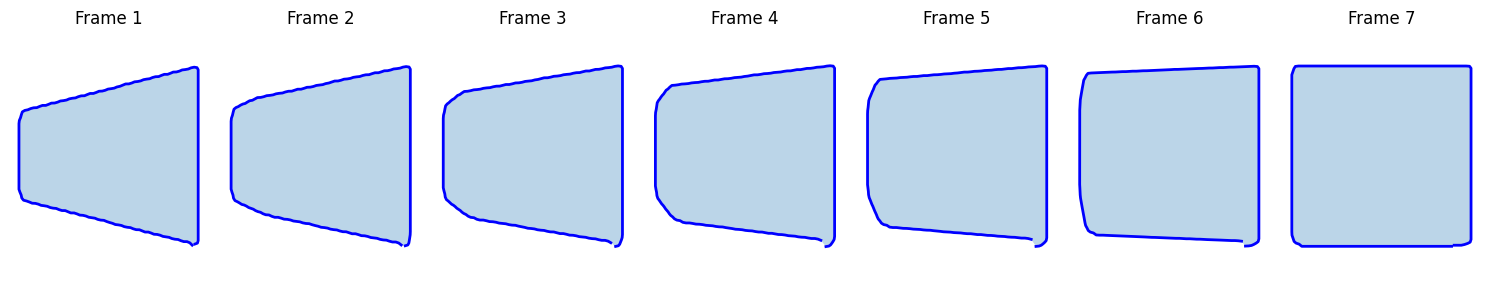

In [11]:

# Extraire la première séquence
morph_sequences = data["morphing_sequences"]
first_key = list(morph_sequences.keys())[1108]
first_sequence = morph_sequences[first_key]["morphing_sequence"]

# ✅ Conversion en liste de np.array
first_sequence_np = [np.array(frame) for frame in first_sequence]

# (Optionnel) Afficher quelques infos
print(f"Paire : {first_key}")
print(f"Nombre de frames : {len(first_sequence_np)}")
print(f"Shape d'une frame : {first_sequence_np[0].shape}")

# #Afficher le morphing
plot_morphing_sequence(first_sequence_np)


In [8]:
import pickle

def count_missing_morphing_sequences(data):
    
    morph_sequences = data.get("morphing_sequences", {})
    total_count = len(morph_sequences)

    # Count missing or empty sequences
    missing_count = sum(
        1 for seq in morph_sequences.values()
        if "morphing_sequence" not in seq or not seq["morphing_sequence"]
    )

    print(f"📊 Total sequences: {total_count}")
    print(f"⚠️  Missing or empty 'morphing_sequence': {missing_count}")

    return missing_count


In [10]:
count_missing_morphing_sequences(data)

📊 Total sequences: 41000
⚠️  Missing or empty 'morphing_sequence': 12730


12730

In [11]:
import pickle

def remove_missing_morphing_sequences(data, output_path):
    """
    Removes entries missing 'morphing_sequence' or having an empty one,
    then saves the cleaned dataset to a pickle file.

    Args:
        data (dict): The loaded dataset containing 'morphing_sequences'
        output_path (str): Path to save the cleaned .pkl file

    Returns:
        dict: The cleaned dataset
    """
    morph_sequences = data.get("morphing_sequences", {})
    total_count = len(morph_sequences)

    # Keep only valid sequences
    cleaned_sequences = {
        key: seq for key, seq in morph_sequences.items()
        if "morphing_sequence" in seq and seq["morphing_sequence"]
    }

    removed_count = total_count - len(cleaned_sequences)

    # Replace old data with cleaned one
    data["morphing_sequences"] = cleaned_sequences

    # Save cleaned dataset
    with open(output_path, "wb") as f:
        pickle.dump(data, f)

    print(f"✅ Cleaning done!")
    print(f"Total sequences: {total_count}")
    print(f"Removed invalid: {removed_count}")
    print(f"Remaining valid: {len(cleaned_sequences)}")
    print(f"💾 Saved cleaned data to: {output_path}")

    return data


In [12]:
# Count missing before cleaning
count_missing_morphing_sequences(data)

# Remove and save
cleaned_data = remove_missing_morphing_sequences(
    data, 
    "/kaggle/working/morphing_dataset_cleaned.pkl"
)

📊 Total sequences: 41000
⚠️  Missing or empty 'morphing_sequence': 12730
✅ Cleaning done!
Total sequences: 41000
Removed invalid: 12730
Remaining valid: 28270
💾 Saved cleaned data to: /kaggle/working/morphing_dataset_cleaned.pkl


In [10]:
count_missing_morphing_sequences(data)

📊 Total sequences: 28270
⚠️  Missing or empty 'morphing_sequence': 0


0

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import json,pickle

class MorphingConditionalVAEDataset(Dataset):
    def __init__(self, pkl_path, sequence_length=7, transform=None):
        """
        Dataset pour Conditional VAE sur les séquences de morphing
        
        Args:
            json_path: Chemin vers le fichier JSON des morphings
            sequence_length: Longueur des séquences de morphing
            transform: Transformations à appliquer
        """
        with open(pkl_path, "rb") as f:
            self.data = pickle.load(f)
        
        self.sequence_length = sequence_length
        self.transform = transform
        
        # Préparer les données
        self.samples = self._prepare_samples()
        
        print(f"Dataset chargé: {len(self.samples)} échantillons")
        
    def _prepare_samples(self):
        """Prépare les échantillons au format (source, target, sequence)"""
        samples = []
        morph_sequences = self.data["morphing_sequences"]
        
        for pair_id, sequence_data in morph_sequences.items():
            try:
                # Vérifier si la séquence est valide
                if "error" in sequence_data or "morphing_sequence" not in sequence_data:
                    continue
                
                morphing_sequence = sequence_data["morphing_sequence"]
                
                # Convertir en numpy arrays
                sequence_np = [np.array(frame, dtype=np.float32) for frame in morphing_sequence]
                
                # Vérifier la longueur de la séquence
                if len(sequence_np) != self.sequence_length:
                    continue
                
                # Extraire source (premier frame) et target (dernier frame)
                source_vector = sequence_np[0]  # Shape: (n_points, 2)
                target_vector = sequence_np[-1] # Shape: (n_points, 2)
                full_sequence = sequence_np     # Shape: (seq_len, n_points, 2)
                
                # Condition: concaténation de source et target
                condition = np.concatenate([source_vector, target_vector], axis=0)  # Shape: (2*n_points, 2)
                
                samples.append({
                    'source': source_vector,
                    'target': target_vector,
                    'condition': condition,
                    'sequence': full_sequence,
                    'pair_id': pair_id,
                    'source_id': sequence_data.get('source_id', ''),
                    'target_id': sequence_data.get('target_id', '')
                })
                
            except Exception as e:
                print(f"Erreur avec {pair_id}: {e}")
                continue
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Convertir en tensors PyTorch
        source_tensor = torch.FloatTensor(sample['source'])          # Shape: (n_points, 2)
        target_tensor = torch.FloatTensor(sample['target'])          # Shape: (n_points, 2)
        condition_tensor = torch.FloatTensor(sample['condition'])    # Shape: (2*n_points, 2)
        sequence_tensor = torch.FloatTensor(sample['sequence'])      # Shape: (seq_len, n_points, 2)
        
        if self.transform:
            source_tensor = self.transform(source_tensor)
            target_tensor = self.transform(target_tensor)
            condition_tensor = self.transform(condition_tensor)
            sequence_tensor = self.transform(sequence_tensor)
        
        return {
            'source': source_tensor,
            'target': target_tensor,
            'condition': condition_tensor,
            'sequence': sequence_tensor,
            'pair_id': sample['pair_id']
        }

# ---------- Visualisation des données préparées ----------
def visualize_prepared_data(dataset, num_samples=3):
    """Visualise quelques échantillons du dataset préparé"""
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 4*num_samples))
    
    for i in range(num_samples):
        sample = dataset[i]
        
        # Source
        source = sample['source'].numpy()
        axes[i, 0].plot(source[:, 0], source[:, 1], 'b-', linewidth=2)
        axes[i, 0].fill(source[:, 0], source[:, 1], alpha=0.3)
        axes[i, 0].set_title(f"Source\n{sample['pair_id']}")
        axes[i, 0].axis('equal')
        axes[i, 0].axis('off')
        
        # Target
        target = sample['target'].numpy()
        axes[i, 1].plot(target[:, 0], target[:, 1], 'r-', linewidth=2)
        axes[i, 1].fill(target[:, 0], target[:, 1], alpha=0.3)
        axes[i, 1].set_title("Target")
        axes[i, 1].axis('equal')
        axes[i, 1].axis('off')
        
        # Condition (source + target)
        condition = sample['condition'].numpy()
        n_points = len(condition) // 2
        source_cond = condition[:n_points]
        target_cond = condition[n_points:]
        
        axes[i, 2].plot(source_cond[:, 0], source_cond[:, 1], 'b-', linewidth=1, alpha=0.7, label='Source')
        axes[i, 2].plot(target_cond[:, 0], target_cond[:, 1], 'r-', linewidth=1, alpha=0.7, label='Target')
        axes[i, 2].set_title("Condition\n(Source + Target)")
        axes[i, 2].axis('equal')
        axes[i, 2].axis('off')
        axes[i, 2].legend()
        
        # Séquence complète (premier frame intermédiaire)
        sequence = sample['sequence'].numpy()
        intermediate = sequence[len(sequence)//2]  # Frame du milieu
        
        axes[i, 3].plot(intermediate[:, 0], intermediate[:, 1], 'g-', linewidth=2)
        axes[i, 3].fill(intermediate[:, 0], intermediate[:, 1], alpha=0.3)
        axes[i, 3].set_title("Frame Intermédiaire")
        axes[i, 3].axis('equal')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# ---------- Alternative: Format plus simple pour VAE standard ----------
class SimpleMorphingDataset(Dataset):
    def __init__(self, pkl_path, sequence_length=7):
        """
        Format plus simple: (condition, full_sequence)
        """
        with open(pkl_path, "rb") as f:
            self.data = pickle.load(f)
        
        self.sequence_length = sequence_length
        self.samples = self._prepare_simple_samples()
        
    def _prepare_simple_samples(self):
        """Prépare les échantillons au format simple (condition, sequence)"""
        samples = []
        morph_sequences = self.data["morphing_sequences"]
        
        for pair_id, sequence_data in morph_sequences.items():
            try:
                if "error" in sequence_data or "morphing_sequence" not in sequence_data:
                    continue
                
                morphing_sequence = sequence_data["morphing_sequence"]
                sequence_np = [np.array(frame, dtype=np.float32) for frame in morphing_sequence]
                
                if len(sequence_np) != self.sequence_length:
                    continue
                
                source_vector = sequence_np[0]
                target_vector = sequence_np[-1]
                full_sequence = np.array(sequence_np)  # Shape: (seq_len, n_points, 2)
                
                # Condition: source et target concaténés et aplatis
                condition = np.concatenate([source_vector.flatten(), target_vector.flatten()])
                
                # Séquence aplatie pour chaque frame
                sequence_flat = full_sequence.reshape(self.sequence_length, -1)  # Shape: (seq_len, n_points*2)
                
                samples.append({
                    'condition': condition,
                    'sequence': sequence_flat,
                    'pair_id': pair_id
                })
                
            except Exception as e:
                continue
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return (
            torch.FloatTensor(sample['condition']),    # Condition: (2*n_points*2,)
            torch.FloatTensor(sample['sequence'])      # Séquence: (seq_len, n_points*2)
        )

# ---------- Utilisation avec DataLoader ----------
def create_data_loaders(json_path, batch_size=32, train_ratio=0.8):
    """Crée les DataLoaders pour l'entraînement"""
    dataset = SimpleMorphingDataset(json_path)
    
    # Split train/validation
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = dataset_size - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Batch size: {batch_size}")
    
    return train_loader, val_loader



In [13]:
# ---------- Utilisation avec DataLoader ----------
def create_data_loaders1(dataset, batch_size=32, train_ratio=0.8):
    
    
    # Split train/validation
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = dataset_size - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Batch size: {batch_size}")
    
    return train_loader, val_loader

=== Chargement du dataset Conditional VAE ===
Dataset chargé: 28270 échantillons
Nombre total d'échantillons valides: 28270

Shape des données:
Source: torch.Size([200, 2])
Target: torch.Size([200, 2])
Condition: torch.Size([400, 2])
Sequence: torch.Size([7, 200, 2])

Visualisation des échantillons...


/tmp/ipykernel_39/2259107748.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  sequence_tensor = torch.FloatTensor(sample['sequence'])      # Shape: (seq_len, n_points, 2)


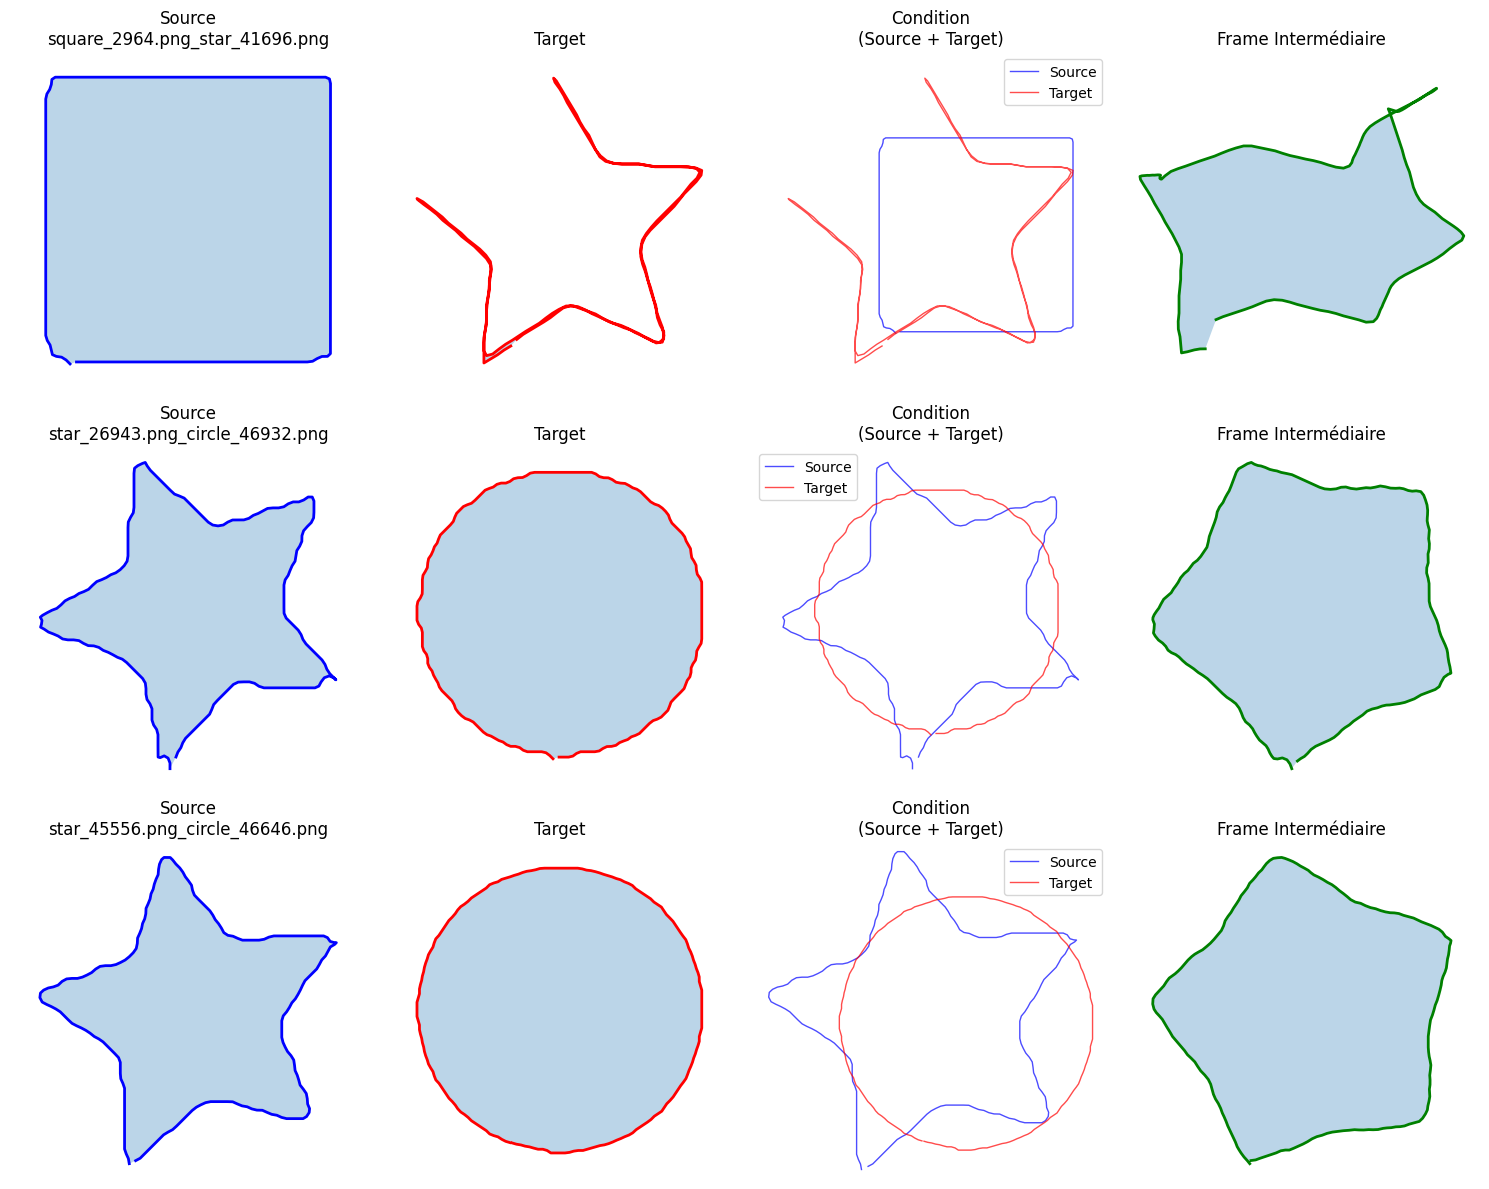

In [14]:
# ---------- Test du dataset ----------
if __name__ == "__main__":
    # Charger le dataset
    json_path = "/kaggle/input/morphing-cleaned-data/morphing_dataset_cleaned (1).pkl"
    
    print("=== Chargement du dataset Conditional VAE ===")
    dataset = MorphingConditionalVAEDataset(json_path, sequence_length=7)
    
    # Afficher les statistiques
    print(f"Nombre total d'échantillons valides: {len(dataset)}")
    
    if len(dataset) > 0:
        # Afficher la forme des données
        sample = dataset[0]
        print(f"\nShape des données:")
        print(f"Source: {sample['source'].shape}")        # (200, 2)
        print(f"Target: {sample['target'].shape}")        # (200, 2)
        print(f"Condition: {sample['condition'].shape}")  # (400, 2)
        print(f"Sequence: {sample['sequence'].shape}")    # (7, 200, 2)
        
        # Visualiser quelques échantillons
        print(f"\nVisualisation des échantillons...")
        visualize_prepared_data(dataset, num_samples=3)
        
        # # Test avec le format simple
        # print(f"\n=== Format simple pour VAE ===")
        # simple_dataset = SimpleMorphingDataset(json_path)
        # condition, sequence = simple_dataset[0]
        # print(f"Condition shape: {condition.shape}")  # (800,) - 200*2*2
        # print(f"Sequence shape: {sequence.shape}")    # (7, 400) - 200*2
        
        # # Créer les DataLoaders
        # print(f"\n=== Création des DataLoaders ===")
        # train_loader, val_loader = create_data_loaders(json_path, batch_size=16)
        
        # # Test d'un batch
        # for batch_idx, (conditions, sequences) in enumerate(train_loader):
        #     print(f"Batch {batch_idx}:")
        #     print(f"  Conditions: {conditions.shape}")  # (batch_size, 800)
        #     print(f"  Sequences: {sequences.shape}")    # (batch_size, 7, 400)
            
        #     if batch_idx == 0:  # Juste le premier batch pour le test
        #         break

# **Model Training**

In [6]:
# Créer les DataLoaders
print(f"\n=== Création des DataLoaders ===")
train_loader, val_loader = create_data_loaders1(dataset, batch_size=16)


=== Création des DataLoaders ===
Train samples: 22616
Val samples: 5654
Batch size: 16


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalVAE(nn.Module):
    def __init__(self, condition_dim, sequence_dim, seq_length, latent_dim=64, hidden_dim=256):
        super(ConditionalVAE, self).__init__()
        
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(sequence_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, sequence_dim),
        )
    
    def encode(self, x, condition):
        # x: (batch_size, seq_length * n_points * 2)
        # condition: (batch_size, condition_dim)
        inputs = torch.cat([x, condition], dim=1)
        h = self.encoder(inputs)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, condition):
        # z: (batch_size, latent_dim)
        # condition: (batch_size, condition_dim)
        inputs = torch.cat([z, condition], dim=1)
        return self.decoder(inputs)
    
    def forward(self, x, condition):
        mu, logvar = self.encode(x, condition)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z, condition)
        return reconstructed, mu, logvar

# Fonction de perte pour VAE
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss

Using device: cuda
Modèle initialisé:
  - Condition dim: 800
  - Sequence dim: 2800
  - Latent dim: 64
Début de l'entraînement...
Device: cuda
Batch size: 16
Latent dim: 64


Epoch 5/50: 100%|██████████| 1414/1414 [00:48<00:00, 29.02it/s]


Epoch 5/50:
  Train Loss: 0.0871 (Recon: 0.0871, KLD: 0.0000)
  Val Loss: 0.0794
--------------------------------------------------


Epoch 10/50: 100%|██████████| 1414/1414 [00:51<00:00, 27.45it/s]


Epoch 10/50:
  Train Loss: 0.0416 (Recon: 0.0415, KLD: 0.0000)
  Val Loss: 0.0410
--------------------------------------------------


Epoch 15/50: 100%|██████████| 1414/1414 [00:51<00:00, 27.40it/s]


Epoch 15/50:
  Train Loss: 0.0316 (Recon: 0.0316, KLD: 0.0000)
  Val Loss: 0.0315
--------------------------------------------------


Epoch 20/50: 100%|██████████| 1414/1414 [00:51<00:00, 27.42it/s]


Epoch 20/50:
  Train Loss: 0.0266 (Recon: 0.0266, KLD: 0.0000)
  Val Loss: 0.0265
--------------------------------------------------


Epoch 25/50: 100%|██████████| 1414/1414 [00:51<00:00, 27.50it/s]


Epoch 25/50:
  Train Loss: 0.0227 (Recon: 0.0227, KLD: 0.0000)
  Val Loss: 0.0228
--------------------------------------------------


Epoch 30/50: 100%|██████████| 1414/1414 [00:51<00:00, 27.31it/s]


Epoch 30/50:
  Train Loss: 0.0191 (Recon: 0.0191, KLD: 0.0000)
  Val Loss: 0.0198
--------------------------------------------------


Epoch 35/50: 100%|██████████| 1414/1414 [00:51<00:00, 27.39it/s]


Epoch 35/50:
  Train Loss: 0.0171 (Recon: 0.0171, KLD: 0.0000)
  Val Loss: 0.0189
--------------------------------------------------


Epoch 40/50: 100%|██████████| 1414/1414 [00:50<00:00, 27.79it/s]


Epoch 40/50:
  Train Loss: 0.0151 (Recon: 0.0151, KLD: 0.0000)
  Val Loss: 0.0165
--------------------------------------------------


Epoch 45/50: 100%|██████████| 1414/1414 [00:50<00:00, 27.77it/s]


Epoch 45/50:
  Train Loss: 0.0136 (Recon: 0.0136, KLD: 0.0000)
  Val Loss: 0.0149
--------------------------------------------------


Epoch 50/50: 100%|██████████| 1414/1414 [00:50<00:00, 27.78it/s]


Epoch 50/50:
  Train Loss: 0.0126 (Recon: 0.0126, KLD: 0.0000)
  Val Loss: 0.0137
--------------------------------------------------


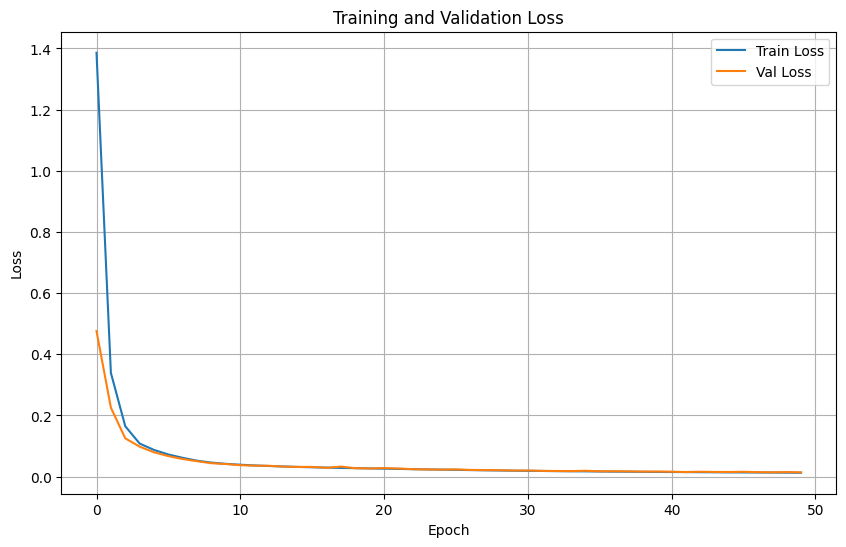

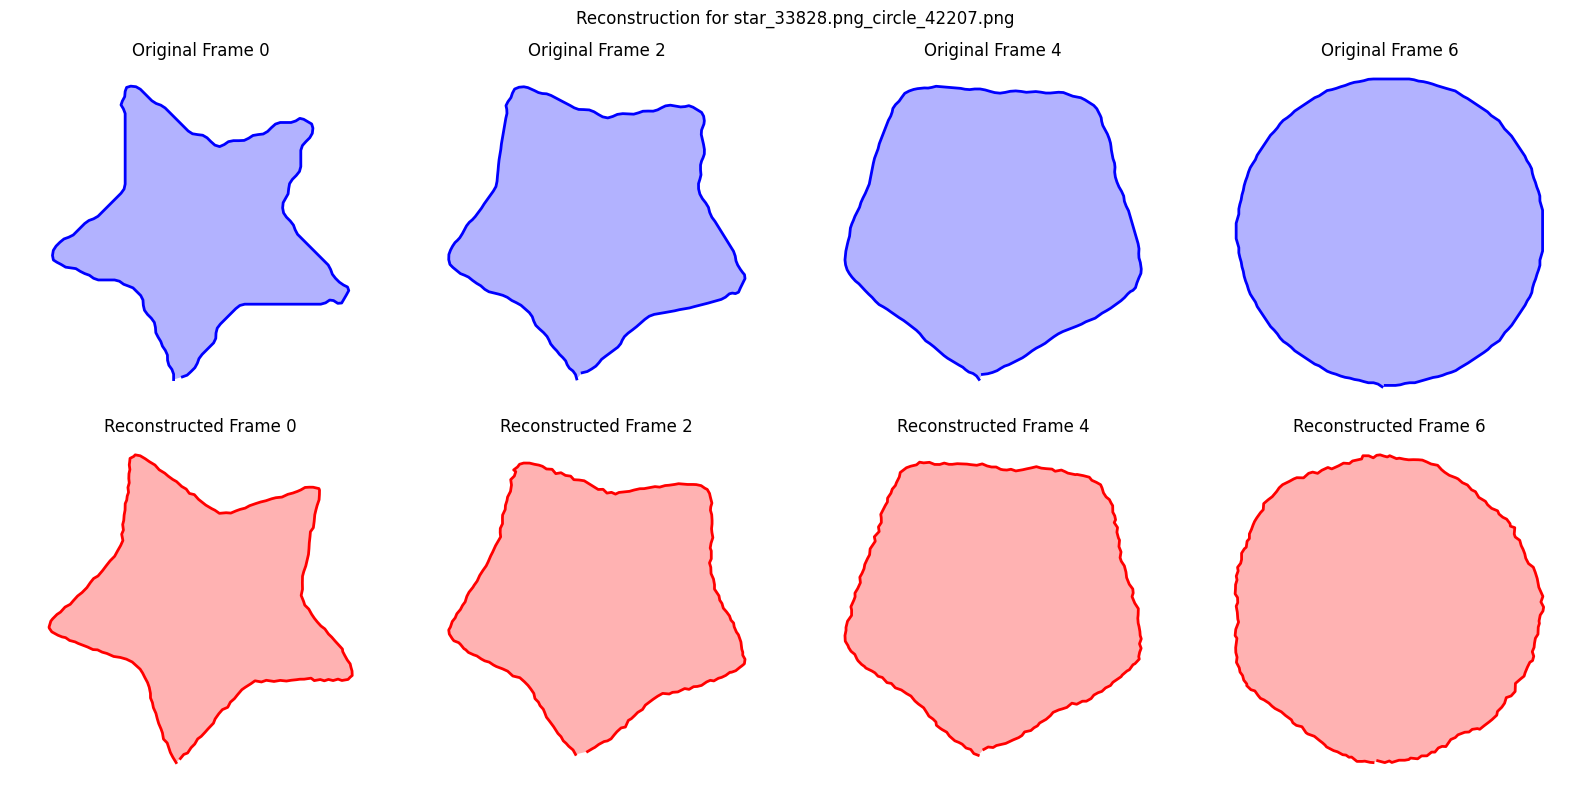

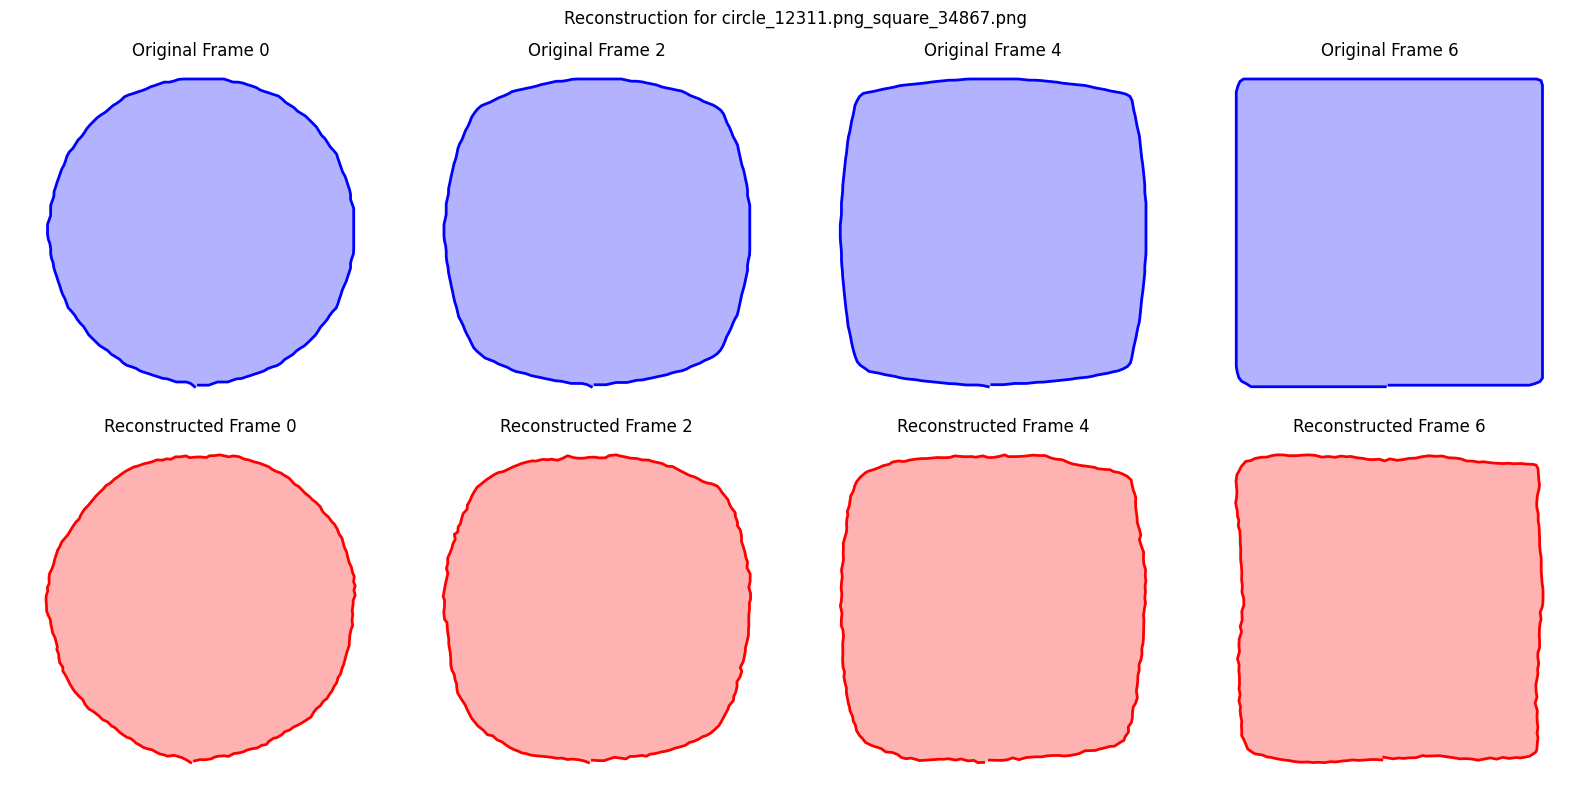

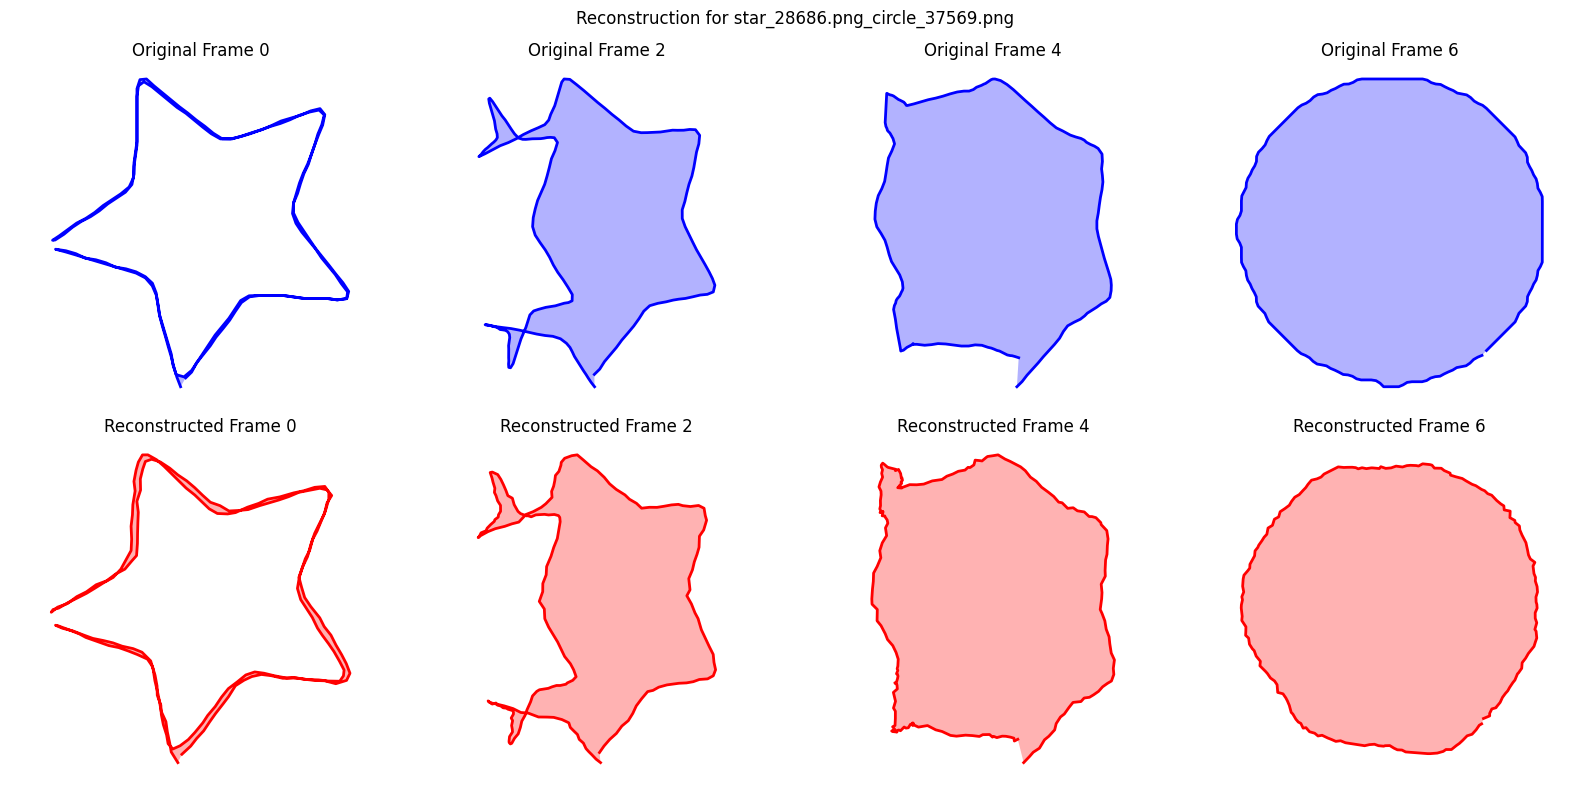

Modèle final sauvegardé!


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

# ---------- Configuration ----------
class Config:
    def __init__(self):
        self.batch_size = 16
        self.latent_dim = 64
        self.hidden_dim = 256
        self.learning_rate = 1e-4
        self.epochs = 50
        self.beta = 1.0  # poids pour le terme KLD
        self.condition_dim = 800  # 2 * 200 * 2 (source + target aplaties)
        self.sequence_dim = 400   # 200 * 2 (un frame aplati)
        self.seq_length = 7

# ---------- Data Preparation ----------
def prepare_data_for_training(dataset):
    """
    Prépare les données au format requis par le CVAE
    """
    conditions = []
    sequences_flat = []
    
    for i in range(len(dataset)):
        sample = dataset[i]
        # Aplatir la séquence pour l'entrée du modèle
        sequence_flat = sample['sequence'].view(-1)  # (7 * 200 * 2) = (2800,)
        conditions.append(sample['condition'])
        sequences_flat.append(sequence_flat)
    
    return torch.stack(conditions), torch.stack(sequences_flat)

# ---------- Training Loop ----------
def train_cvae(model, train_loader, val_loader, config, device):
    """
    Boucle d'entraînement pour le Conditional VAE
    """
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    train_losses = []
    val_losses = []
    
    print("Début de l'entraînement...")
    print(f"Device: {device}")
    print(f"Batch size: {config.batch_size}")
    print(f"Latent dim: {config.latent_dim}")
    
    for epoch in range(config.epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kld_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs}'):
            # Récupérer les données du batch
            conditions = batch['condition'].to(device)  # (batch_size, 400, 2)
            sequences = batch['sequence'].to(device)    # (batch_size, 7, 200, 2)
            
            # Aplatir les séquences pour l'entrée du modèle
            batch_size = sequences.shape[0]
            sequences_flat = sequences.view(batch_size, -1)  # (batch_size, 7*200*2)
            
            # Aplatir les conditions (elles sont déjà en (batch_size, 400, 2))
            conditions_flat = conditions.view(batch_size, -1)  # (batch_size, 400*2)
            
            # Forward pass
            optimizer.zero_grad()
            reconstructed_flat, mu, logvar = model(sequences_flat, conditions_flat)
            
            # Calcul de la loss
            loss = vae_loss(reconstructed_flat, sequences_flat, mu, logvar, config.beta)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            # Calcul des composantes de la loss pour le logging
            with torch.no_grad():
                recon_loss = F.mse_loss(reconstructed_flat, sequences_flat, reduction='sum')
                kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                train_recon_loss += recon_loss.item()
                train_kld_loss += kld_loss.item()
        
        # Phase de validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                conditions = batch['condition'].to(device)
                sequences = batch['sequence'].to(device)
                
                batch_size = sequences.shape[0]
                sequences_flat = sequences.view(batch_size, -1)
                conditions_flat = conditions.view(batch_size, -1)
                
                reconstructed_flat, mu, logvar = model(sequences_flat, conditions_flat)
                loss = vae_loss(reconstructed_flat, sequences_flat, mu, logvar, config.beta)
                val_loss += loss.item()
        
        # Calcul des moyennes
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_train_recon = train_recon_loss / len(train_loader.dataset)
        avg_train_kld = train_kld_loss / len(train_loader.dataset)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Affichage des métriques
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{config.epochs}:')
            print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, KLD: {avg_train_kld:.4f})')
            print(f'  Val Loss: {avg_val_loss:.4f}')
            print('-' * 50)
        
        # Sauvegarde du modèle périodique
        if (epoch + 1) % 20 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, f'cvae_checkpoint_epoch_{epoch+1}.pth')
    
    return train_losses, val_losses

# ---------- Visualization Functions ----------
def plot_training_curves(train_losses, val_losses):
    """Affiche les courbes d'apprentissage"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_reconstructions(model, dataloader, device, num_examples=3):
    """Visualise quelques reconstructions"""
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            conditions = batch['condition'].to(device)
            sequences = batch['sequence'].to(device)
            pair_ids = batch['pair_id']
            
            batch_size = sequences.shape[0]
            sequences_flat = sequences.view(batch_size, -1)
            conditions_flat = conditions.view(batch_size, -1)
            
            reconstructed_flat, _, _ = model(sequences_flat, conditions_flat)
            reconstructed = reconstructed_flat.view(batch_size, 7, 200, 2)
            
            # Afficher les premiers exemples du batch
            for i in range(min(num_examples, batch_size)):
                fig, axes = plt.subplots(2, 4, figsize=(16, 8))
                
                # Original
                for j in range(4):
                    if j < 3:
                        frame_idx = j * 2
                    else:
                        frame_idx = 6
                    
                    original_frame = sequences[i, frame_idx].cpu().numpy()
                    reconstructed_frame = reconstructed[i, frame_idx].cpu().numpy()
                    
                    # Original
                    axes[0, j].plot(original_frame[:, 0], original_frame[:, 1], 'b-', linewidth=2)
                    axes[0, j].fill(original_frame[:, 0], original_frame[:, 1], 'blue', alpha=0.3)
                    axes[0, j].set_title(f'Original Frame {frame_idx}')
                    axes[0, j].axis('equal')
                    axes[0, j].axis('off')
                    
                    # Reconstruit
                    axes[1, j].plot(reconstructed_frame[:, 0], reconstructed_frame[:, 1], 'r-', linewidth=2)
                    axes[1, j].fill(reconstructed_frame[:, 0], reconstructed_frame[:, 1], 'red', alpha=0.3)
                    axes[1, j].set_title(f'Reconstructed Frame {frame_idx}')
                    axes[1, j].axis('equal')
                    axes[1, j].axis('off')
                
                plt.suptitle(f'Reconstruction for {pair_ids[i]}')
                plt.tight_layout()
                plt.show()
            
            break  # Juste le premier batch

# ---------- Generation Function ----------
def generate_morphing_sequence(model, source, target, device):
    """
    Génère une séquence de morphing à partir d'une source et target
    
    Args:
        model: Le modèle CVAE entraîné
        source: Tensor de shape (200, 2) - forme source
        target: Tensor de shape (200, 2) - forme target
        device: Device pour les calculs
    """
    model.eval()
    with torch.no_grad():
        # Préparer la condition
        condition = torch.cat([source, target], dim=0)  # (400, 2)
        condition_flat = condition.view(-1).unsqueeze(0).to(device)  # (1, 800)
        
        # Générer à partir du bruit
        z = torch.randn(1, model.latent_dim).to(device)
        generated_flat = model.decode(z, condition_flat)
        
        # Remettre en forme
        generated = generated_flat.view(1, 7, 200, 2)
        return generated.squeeze(0).cpu().numpy()  # (7, 200, 2)

# ---------- Main Training Script ----------
def main():
    # Configuration
    config = Config()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Chargement des données
    # print("Chargement des datasets...")
    # train_dataset = MorphingConditionalVAEDataset("train_data.pkl", sequence_length=7)
    # val_dataset = MorphingConditionalVAEDataset("val_data.pkl", sequence_length=7)
    
    # # Création des DataLoaders
    # train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    # print(f"Train samples: {len(train_dataset)}")
    # print(f"Val samples: {len(val_dataset)}")
    
    # Initialisation du modèle
    model = ConditionalVAE(
        condition_dim=config.condition_dim,
        sequence_dim=config.sequence_dim * config.seq_length,  # 400 * 7 = 2800
        seq_length=config.seq_length,
        latent_dim=config.latent_dim,
        hidden_dim=config.hidden_dim
    ).to(device)
    
    print(f"Modèle initialisé:")
    print(f"  - Condition dim: {config.condition_dim}")
    print(f"  - Sequence dim: {config.sequence_dim * config.seq_length}")
    print(f"  - Latent dim: {config.latent_dim}")
    
    # Entraînement
    train_losses, val_losses = train_cvae(model, train_loader, val_loader, config, device)
    
    # Visualisation des résultats
    plot_training_curves(train_losses, val_losses)
    visualize_reconstructions(model, val_loader, device)
    
    # Sauvegarde du modèle final
    torch.save(model.state_dict(), 'conditional_vae_final.pth')
    print("Modèle final sauvegardé!")

# ---------- Test de génération ----------
def test_generation():
    """Teste la génération avec le modèle entraîné"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Charger le modèle
    config = Config()
    model = ConditionalVAE(
        condition_dim=config.condition_dim,
        sequence_dim=config.sequence_dim * config.seq_length,
        seq_length=config.seq_length,
        latent_dim=config.latent_dim,
        hidden_dim=config.hidden_dim
    ).to(device)
    
    model.load_state_dict(torch.load('conditional_vae_final.pth'))
    model.eval()
    
    # Charger quelques données de test
    test_dataset = MorphingConditionalVAEDataset("val_data.pkl", sequence_length=7)
    test_sample = test_dataset[0]
    
    # Générer une séquence
    source = test_sample['source']  # (200, 2)
    target = test_sample['target']  # (200, 2)
    
    generated_sequence = generate_morphing_sequence(model, source, target, device)
    
    # Visualiser la séquence générée
    fig, axes = plt.subplots(1, 7, figsize=(21, 3))
    for i in range(7):
        frame = generated_sequence[i]
        axes[i].plot(frame[:, 0], frame[:, 1], 'g-', linewidth=2)
        axes[i].fill(frame[:, 0], frame[:, 1], 'green', alpha=0.3)
        axes[i].set_title(f'Generated Frame {i}')
        axes[i].axis('equal')
        axes[i].axis('off')
    
    plt.suptitle('Generated Morphing Sequence')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
    # test_generation()  # Décommentez pour tester après l'entraînement

In [18]:
# ---------- Generation Function ----------
def generate_morphing_sequence(model, source, target, device):
    """
    Génère une séquence de morphing à partir d'une source et target
    
    Args:
        model: Le modèle CVAE entraîné
        source: Tensor de shape (200, 2) - forme source
        target: Tensor de shape (200, 2) - forme target
        device: Device pour les calculs
    """
    model.eval()
    with torch.no_grad():
        # Préparer la condition
        condition = torch.cat([source, target], dim=0)  # (400, 2)
        condition_flat = condition.view(-1).unsqueeze(0).to(device)  # (1, 800)
        
        # Générer à partir du bruit
        z = torch.randn(1, model.latent_dim).to(device)
        generated_flat = model.decode(z, condition_flat)
        
        # Remettre en forme
        generated = generated_flat.view(1, 7, 200, 2)
        return generated.squeeze(0).cpu().numpy()  # (7, 200, 2)

def test_generation():
    """Teste la génération avec le modèle entraîné"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Charger le modèle
    config = Config()
    model = ConditionalVAE(
        condition_dim=config.condition_dim,
        sequence_dim=config.sequence_dim * config.seq_length,
        seq_length=config.seq_length,
        latent_dim=config.latent_dim,
        hidden_dim=config.hidden_dim
    ).to(device)
    
    model.load_state_dict(torch.load('conditional_vae_final.pth'))
    model.eval()
    
    # Charger quelques données de test
    test_dataset = MorphingConditionalVAEDataset("val_data.pkl", sequence_length=7)
    test_sample = test_dataset[0]
    
    # Générer une séquence
    source = test_sample['source']  # (200, 2)
    target = test_sample['target']  # (200, 2)
    
    generated_sequence = generate_morphing_sequence(model, source, target, device)
    
    # Visualiser la séquence générée
    fig, axes = plt.subplots(1, 7, figsize=(21, 3))
    for i in range(7):
        frame = generated_sequence[i]
        axes[i].plot(frame[:, 0], frame[:, 1], 'g-', linewidth=2)
        axes[i].fill(frame[:, 0], frame[:, 1], 'green', alpha=0.3)
        axes[i].set_title(f'Generated Frame {i}')
        axes[i].axis('equal')
        axes[i].axis('off')
    
    plt.suptitle('Generated Morphing Sequence')
    plt.tight_layout()
    plt.show()

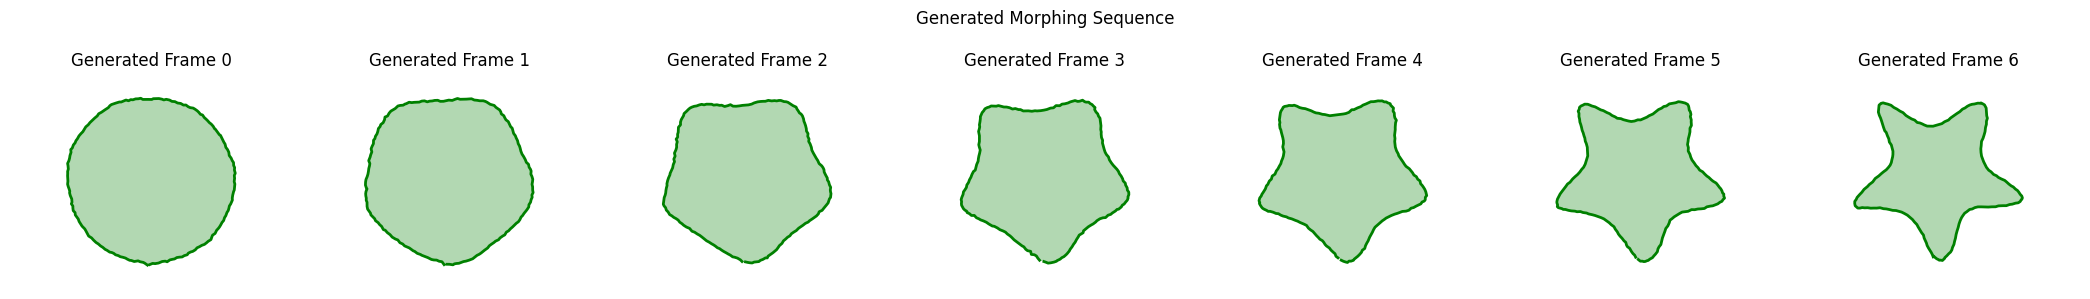

In [24]:
# ---------- Configuration ----------
class Config:
    def __init__(self):
        self.batch_size = 16
        self.latent_dim = 64
        self.hidden_dim = 256
        self.learning_rate = 1e-4
        self.epochs = 50
        self.beta = 1.0  # poids pour le terme KLD
        self.condition_dim = 800  # 2 * 200 * 2 (source + target aplaties)
        self.sequence_dim = 400   # 200 * 2 (un frame aplati)
        self.seq_length = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Charger le modèle
config = Config()
model = ConditionalVAE(
    condition_dim=config.condition_dim,
    sequence_dim=config.sequence_dim * config.seq_length,
    seq_length=config.seq_length,
    latent_dim=config.latent_dim,
    hidden_dim=config.hidden_dim
).to(device)

model.load_state_dict(torch.load('/kaggle/input/cvae-for-morhping-generation/pytorch/final-version/1/conditional_vae_final.pth'))
model.eval()
test_sample = dataset[7751]
    
# Générer une séquence
source = test_sample['source']  # (200, 2)
target = test_sample['target']  # (200, 2)

generated_sequence = generate_morphing_sequence(model, source, target, device)

# Visualiser la séquence générée
fig, axes = plt.subplots(1, 7, figsize=(21, 3))
for i in range(7):
    frame = generated_sequence[i]
    axes[i].plot(frame[:, 0], frame[:, 1], 'g-', linewidth=2)
    axes[i].fill(frame[:, 0], frame[:, 1], 'green', alpha=0.3)
    axes[i].set_title(f'Generated Frame {i}')
    axes[i].axis('equal')
    axes[i].axis('off')

plt.suptitle('Generated Morphing Sequence')
plt.tight_layout()
plt.show()

# **Model Performance Against SRVF Method**

📊 **Smoothness Metrics**
🔄 **Spatial Smoothness**
Spatial regularity of motion
Low value = UNIFORM MOVEMENT ✅
Measures if all points move coherently in space at each instant.

⏱️ **Temporal Smoothness**
Temporal regularity of motion
Low value = SMOOTH TRANSITION ✅
Measures if movement speed remains consistent between frames.

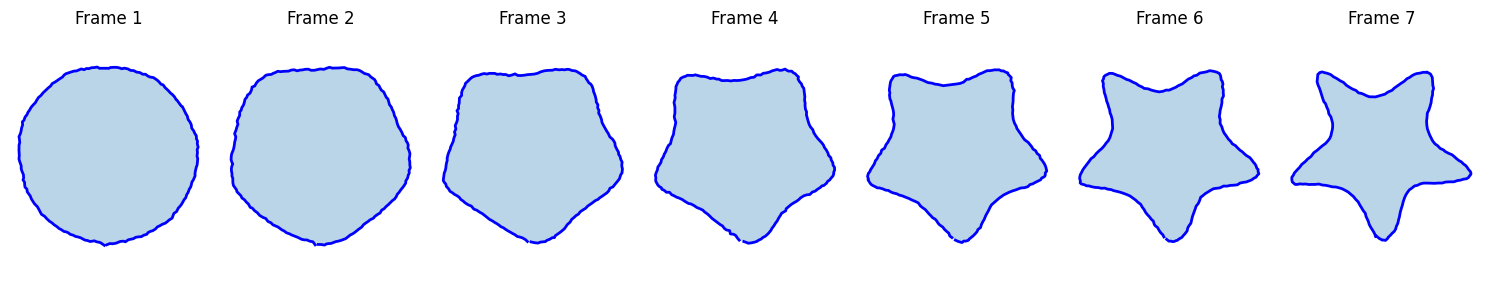

In [30]:
plot_morphing_sequence(generated_sequence)

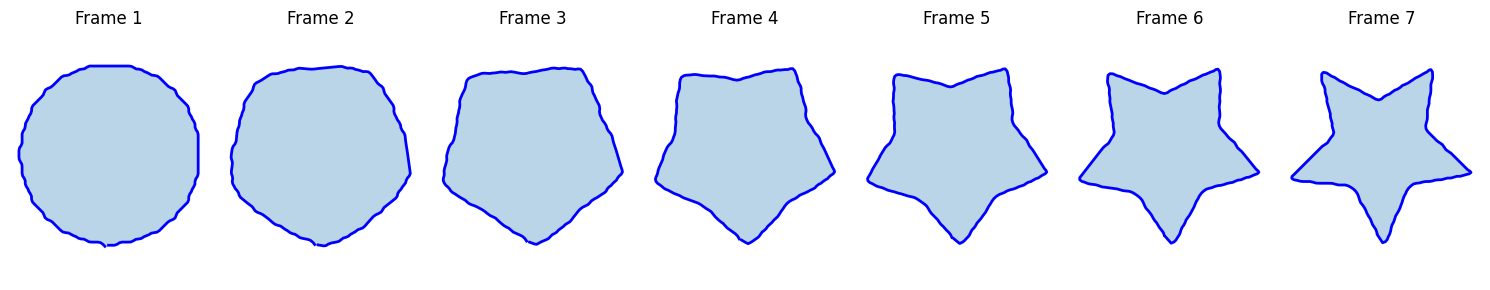

In [27]:
sample=dataset[7751]
sequence_np = sample['sequence'].numpy()
plot_morphing_sequence(sequence_np)

=== SMOOTHNESS COMPARISON TEST ===
Original sequence shape: (7, 200, 2)
Generated sequence shape: (7, 200, 2)
=== SMOOTHNESS COMPARISON ===
ORIGINAL SEQUENCE:
  Spatial Smoothness:  1.597993
  Temporal Smoothness: 0.000001
GENERATED SEQUENCE:
  Spatial Smoothness:  2.912578
  Temporal Smoothness: 0.000064

=== INTERPRETATION ===
Spatial Smoothness Ratio: 1.823
  → Generated sequence has WORSE spatial smoothness
Temporal Smoothness Ratio: 79.421
  → Generated sequence has WORSE temporal smoothness


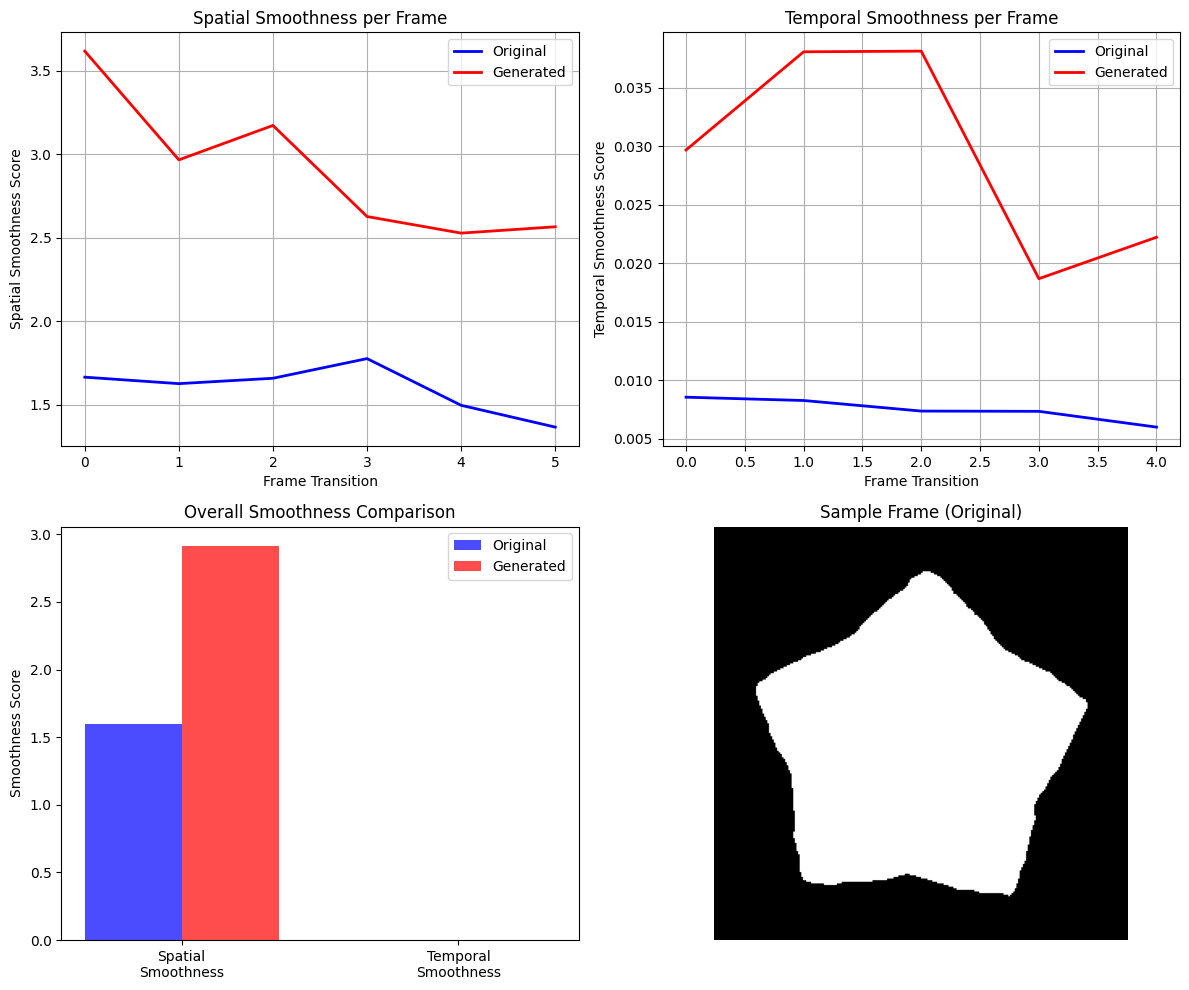

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sequences_to_images(original_sequence, generated_sequence, image_size=256):
    """
    Convertit les séquences de contours en images binaires pour l'optical flow
    
    Args:
        original_sequence: numpy array de shape (seq_len, n_points, 2)
        generated_sequence: numpy array de shape (seq_len, n_points, 2)
        image_size: taille de l'image de sortie
    
    Returns:
        original_images, generated_images: listes d'images binaires
    """
    def create_binary_image(sequence_frame, img_size):
        """Crée une image binaire à partir d'un frame de contour"""
        img = np.zeros((img_size, img_size), dtype=np.uint8)
        
        # Normaliser les coordonnées
        frame = sequence_frame.copy()
        frame = frame - frame.min(axis=0)
        if frame.max() > 0:
            frame = frame / frame.max()
            frame = (frame * (img_size * 0.8)).astype(int)
        
        # Centrer
        offset = (img_size - frame.max(axis=0)) // 2
        frame += offset
        
        # Dessiner le contour fermé
        pts = frame.reshape((-1, 1, 2)).astype(np.int32)
        cv2.fillPoly(img, [pts], 255)
        
        return img
    
    original_images = []
    generated_images = []
    
    for i in range(len(original_sequence)):
        orig_img = create_binary_image(original_sequence[i], image_size)
        gen_img = create_binary_image(generated_sequence[i], image_size)
        
        original_images.append(orig_img)
        generated_images.append(gen_img)
    
    return original_images, generated_images

def compute_optical_flow_smoothness(gray_frames):
    """Compute spatial and temporal smoothness of optical flow."""
    spatial_scores = []
    temporal_scores = []
    prev_flow = None

    for i in range(len(gray_frames) - 1):
        f1, f2 = gray_frames[i], gray_frames[i + 1]
        
        # Calculer l'optical flow
        flow = cv2.calcOpticalFlowFarneback(
            f1, f2, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2,
            flags=0
        )
        
        # Spatial smoothness - régularité spatiale du flow
        fx, fy = flow[..., 0], flow[..., 1]
        grad_x = cv2.Sobel(fx, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(fy, cv2.CV_32F, 0, 1, ksize=3)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        spatial_scores.append(np.mean(grad_mag))

        # Temporal smoothness - régularité temporelle du flow
        if prev_flow is not None:
            diff = np.linalg.norm(flow - prev_flow) / flow.size
            temporal_scores.append(diff)

        prev_flow = flow

    return {
        'spatial_smoothness': float(np.mean(spatial_scores)),
        'temporal_smoothness': float(np.var(temporal_scores)) if temporal_scores else 0.0,
        'spatial_scores': spatial_scores,
        'temporal_scores': temporal_scores
    }

def compare_smoothness(original_sequence, generated_sequence, image_size=256):
    """
    Compare la smoothness entre séquence originale et générée
    """
    # Convertir les séquences en images
    original_images, generated_images = sequences_to_images(
        original_sequence, generated_sequence, image_size
    )
    
    # Calculer les métriques de smoothness
    orig_metrics = compute_optical_flow_smoothness(original_images)
    gen_metrics = compute_optical_flow_smoothness(generated_images)
    
    return {
        'original': orig_metrics,
        'generated': gen_metrics,
        'original_images': original_images,
        'generated_images': generated_images
    }

def visualize_smoothness_comparison(results):
    """
    Visualise la comparaison de smoothness
    """
    orig_metrics = results['original']
    gen_metrics = results['generated']
    
    print("=== SMOOTHNESS COMPARISON ===")
    print(f"ORIGINAL SEQUENCE:")
    print(f"  Spatial Smoothness:  {orig_metrics['spatial_smoothness']:.6f}")
    print(f"  Temporal Smoothness: {orig_metrics['temporal_smoothness']:.6f}")
    print(f"GENERATED SEQUENCE:")
    print(f"  Spatial Smoothness:  {gen_metrics['spatial_smoothness']:.6f}")
    print(f"  Temporal Smoothness: {gen_metrics['temporal_smoothness']:.6f}")
    print()
    
    # Interprétation
    spatial_ratio = gen_metrics['spatial_smoothness'] / orig_metrics['spatial_smoothness']
    temporal_ratio = gen_metrics['temporal_smoothness'] / orig_metrics['temporal_smoothness']
    
    print("=== INTERPRETATION ===")
    print(f"Spatial Smoothness Ratio: {spatial_ratio:.3f}")
    if spatial_ratio < 0.8:
        print("  → Generated sequence has BETTER spatial smoothness")
    elif spatial_ratio > 1.2:
        print("  → Generated sequence has WORSE spatial smoothness")
    else:
        print("  → Similar spatial smoothness")
    
    print(f"Temporal Smoothness Ratio: {temporal_ratio:.3f}")
    if temporal_ratio < 0.8:
        print("  → Generated sequence has BETTER temporal smoothness")
    elif temporal_ratio > 1.2:
        print("  → Generated sequence has WORSE temporal smoothness")
    else:
        print("  → Similar temporal smoothness")
    
    # Visualisation graphique
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Spatial smoothness par frame
    axes[0, 0].plot(orig_metrics['spatial_scores'], 'b-', label='Original', linewidth=2)
    axes[0, 0].plot(gen_metrics['spatial_scores'], 'r-', label='Generated', linewidth=2)
    axes[0, 0].set_title('Spatial Smoothness per Frame')
    axes[0, 0].set_xlabel('Frame Transition')
    axes[0, 0].set_ylabel('Spatial Smoothness Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Temporal smoothness par frame
    axes[0, 1].plot(orig_metrics['temporal_scores'], 'b-', label='Original', linewidth=2)
    axes[0, 1].plot(gen_metrics['temporal_scores'], 'r-', label='Generated', linewidth=2)
    axes[0, 1].set_title('Temporal Smoothness per Frame')
    axes[0, 1].set_xlabel('Frame Transition')
    axes[0, 1].set_ylabel('Temporal Smoothness Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Bar plot comparison
    metrics_names = ['Spatial\nSmoothness', 'Temporal\nSmoothness']
    original_values = [orig_metrics['spatial_smoothness'], orig_metrics['temporal_smoothness']]
    generated_values = [gen_metrics['spatial_smoothness'], gen_metrics['temporal_smoothness']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, original_values, width, label='Original', color='blue', alpha=0.7)
    axes[1, 0].bar(x + width/2, generated_values, width, label='Generated', color='red', alpha=0.7)
    axes[1, 0].set_title('Overall Smoothness Comparison')
    axes[1, 0].set_ylabel('Smoothness Score')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics_names)
    axes[1, 0].legend()
    
    # Sample images
    axes[1, 1].imshow(results['original_images'][3], cmap='gray')
    axes[1, 1].set_title('Sample Frame (Original)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'spatial_ratio': spatial_ratio,
        'temporal_ratio': temporal_ratio
    }

# ---------- UTILISATION PRATIQUE ----------

# Supposons que vous avez vos deux séquences
# original_sequence = ...  # shape: (7, 200, 2)
# generated_sequence = ...  # shape: (7, 200, 2)

def test_smoothness_comparison():
    """Teste la comparaison de smoothness sur vos séquences"""
    
    # Charger vos séquences (exemple avec vos données)
    sample = dataset[7751]
    original_sequence = sample['sequence'].numpy()  # (7, 200, 2)
    
    # Pour le test, créer une séquence générée simulée
    generated_sequence = original_sequence.copy()
    
    # Ajouter différents types de bruit pour tester
    # Option 1: Bruit gaussien (mauvaise smoothness)
    noise = np.random.normal(0, 0.02, generated_sequence.shape)
    generated_sequence += noise
    
    # Option 2: Lissage (meilleure smoothness)
    # from scipy import ndimage
    # for i in range(generated_sequence.shape[0]):
    #     generated_sequence[i] = ndimage.gaussian_filter(generated_sequence[i], sigma=1.0)
    
    print("=== SMOOTHNESS COMPARISON TEST ===")
    print(f"Original sequence shape: {original_sequence.shape}")
    print(f"Generated sequence shape: {generated_sequence.shape}")
    
    # Comparer la smoothness
    results = compare_smoothness(original_sequence, generated_sequence, image_size=256)
    
    # Visualiser les résultats
    ratios = visualize_smoothness_comparison(results)
    
    return results, ratios

# Lancer le test
if __name__ == "__main__":
    results, ratios = test_smoothness_comparison()
    
    # Sauvegarder les résultats si besoin
    np.savez('smoothness_comparison.npz',
             original_metrics=results['original'],
             generated_metrics=results['generated'],
             ratios=ratios)